In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install --upgrade segmentation-models-pytorch torch

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
"""
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,  RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
"""
from scipy.stats import randint
import matplotlib.pyplot as plt
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
from sklearn.model_selection import train_test_split

from skimage import transform
#import tensorflow as tf
#import segmentation_models as sm
#from tf.keras import layers, models

from PIL import Image

import seaborn as sns

torch.multiprocessing.set_start_method('spawn', force=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PYDEVD_DISABLE_FILE_VALIDATION=1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir model

In [ ]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/AI MLCourse/Capstone/MultiSourceSatelliteImagerySegmentation/images'
masks_dir = '/content/drive/MyDrive/Colab Notebooks/AI MLCourse/Capstone/MultiSourceSatelliteImagerySegmentation/masks'
models_dir ='/content/drive/MyDrive/Colab Notebooks/AI MLCourse/Capstone/MultiSourceSatelliteImagerySegmentation/models'

images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


Number of images: 203
Number of masks: 203


In [ ]:
train_images=np.array(train_images)
train_masks=np.array(train_masks)
val_images=np.array(val_images)
val_masks=np.array(val_masks)

In [ ]:
#Generate class label map
#Building: #3C1098
#Land (unpaved area): #8429F6
#Road: #6EC1E4
#Vegetation: #FEDD3A
#Water: #E2A929
#Unlabeled: #9B9B9B
#Object
color_map = {
    (60, 16, 152):0,   # Building #Dark voilet
    (132, 41, 246):1,  # Land (unpaved area) # Bright voilet
    (110, 193, 228):2, # Road # soft blue
    (254, 221, 58):3,  # Vegetation # Bright yellow
    (226, 169, 41):4,  # Water # Bright orange
    (155, 155, 155):5  # Object # Dark Gray
}



In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np


# Define the augmentation probabilities/parameters
flip_prob = 0.5
rot_degrees = 10
color_jitter_params = (0.2, 0.2, 0.2, 0.1)

# Target sizes for different models
UNET_TARGET_SIZE = (512, 512) # Original target size for UNet
DEEPLABV3_TARGET_SIZE = (520, 520) # Standard target size for torchvision DeepLabV3 models

# Transformations for images including data augmentation (for UNet)
transform_unet = transforms.Compose([
      transforms.RandomHorizontalFlip(p=flip_prob),
      transforms.RandomRotation(rot_degrees),
      transforms.Resize(UNET_TARGET_SIZE),
      transforms.ColorJitter(*color_jitter_params),
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Transformations for labels (masks) for UNet
label_transform_unet = transforms.Compose([
    transforms.RandomHorizontalFlip(p=flip_prob),
    transforms.RandomRotation(rot_degrees),
    transforms.Resize(UNET_TARGET_SIZE, interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# New: Explicit transformations for DeepLabV3 images
transform_deeplabv3_image = transforms.Compose([
    transforms.RandomHorizontalFlip(p=flip_prob),
    transforms.RandomRotation(rot_degrees),
    transforms.Resize(DEEPLABV3_TARGET_SIZE), # Ensure exact size for DeepLabV3 input LAST
    transforms.ColorJitter(*color_jitter_params),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Transformations for labels (masks) for DeepLabV3
label_transform_deeplabv3 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=flip_prob),
    transforms.RandomRotation(rot_degrees),
    transforms.Resize(DEEPLABV3_TARGET_SIZE, interpolation=Image.NEAREST), # Ensure exact size for DeepLabV3 input LAST
    transforms.ToTensor(),
])

In [ ]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [ ]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    # Removed: print(f"DEBUG: Inside rgb_to_2D_label. Input label type: {type(label)}, shape: {label.shape}, dtype: {label.dtype}")

    # Ensure label is a numpy array and has 3 channels (HxWx3)
    if not isinstance(label, np.ndarray) or label.ndim != 3 or label.shape[2] != 3:
        # Removed: print(f"WARNING: Input label to rgb_to_2D_label does not have expected HxWx3 shape. Got {label.shape}")
        raise ValueError(f"Input to rgb_to_2D_label must be an HxWx3 numpy array, but got shape {label.shape}")

    height, width, _ = label.shape
    label_seg = np.zeros((height, width), dtype=np.uint8) # Initialize as a 2D array (HxW)

    # Removed: print(f"DEBUG: Type of Building: {type(Building)}, Land: {type(Land)}, Road: {type(Road)}, Vegetation: {type(Vegetation)}, Water: {type(Water)}, Unlabeled: {type(Unlabeled)}")
    # Removed: print(f"DEBUG: Building value: {Building}, type: {type(Building)}, dtype: {Building.dtype}")
    # Removed: print(f"DEBUG: Land value: {Land}, type: {type(Land)}, dtype: {Land.dtype}")
    # Removed: print(f"DEBUG: Road value: {Road}, type: {type(Road)}, dtype: {Road.dtype}")
    # Removed: print(f"DEBUG: Vegetation value: {Vegetation}, type: {type(Vegetation)}, dtype: {Vegetation.dtype}")
    # Removed: print(f"DEBUG: Water value: {Water}, type: {type(Water)}, dtype: {Water.dtype}")
    # Removed: print(f"DEBUG: Unlabeled value: {Unlabeled}, type: {type(Unlabeled)}, dtype: {Unlabeled.dtype}")

    try:
        label_seg[np.all(label == Building, axis=-1)] = 0
    except Exception as e:
        print(f"ERROR: Failed at Building comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Land, axis=-1)] = 1
    except Exception as e:
        print(f"ERROR: Failed at Land comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Road, axis=-1)] = 2
    except Exception as e:
        print(f"ERROR: Failed at Road comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Vegetation, axis=-1)] = 3
    except Exception as e:
        print(f"ERROR: Failed at Vegetation comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Water, axis=-1)] = 4
    except Exception as e:
        print(f"ERROR: Failed at Water comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Unlabeled, axis=-1)] = 5
    except Exception as e:
        print(f"ERROR: Failed at Unlabeled comparison: {e}")
        raise

    return label_seg

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F

class SegmentationData:
  def __init__(self, images_dir, images_list, masks_list):
    self.images_dir=images_dir
    self.images_list=images_list
    self.masks_list=masks_list

  def __len__(self):
      return len(self.images_list)

  def __getitem__(self, idx):
    image_path=os.path.join(self.images_dir, self.images_list[idx])
    image = Image.open(image_path).convert("RGB") # Ensure RGB conversion

    mask_path=os.path.join(masks_dir, self.masks_list[idx]) # Correctly use self.masks_list
    mask = Image.open(mask_path).convert("RGB") # Ensure RGB conversion

    # Apply transformations based on which model is currently being trained
    if deeplabv3_model: # Prioritize DeepLabV3 transformations
      image = transform_deeplabv3_image(image) # Use explicit DeepLabV3 image transform
      mask = label_transform_deeplabv3(mask) # Custom mask transform for DeepLabV3
      image = image.to(torch.float32)
      mask = mask.to(torch.float32)

    elif resnet_model: # Use UNet transformations if DeepLabV3 is not active
      image = transform_unet(image) # Custom image transform for UNet
      mask = label_transform_unet(mask) # Custom mask transform for UNet
      image = image.to(torch.float64)
      mask = mask.to(torch.float64)

    else: # Fallback if neither flag is set (should ideally not happen if flags are correctly managed)
      image = transform_unet(image) # Assume default to UNet's transform
      mask = label_transform_unet(mask) # Assume default to UNet's transform
      image = image.to(torch.float32)
      mask = mask.to(torch.float32)


    return image, mask

segmentation_data_train=SegmentationData(images_dir, train_images, train_masks)
segmentation_data_val=SegmentationData(images_dir, val_images, val_masks)

train_data_loader=DataLoader(segmentation_data_train, shuffle=True, pin_memory=False, num_workers=0, drop_last=True)
val_data_loader=DataLoader(segmentation_data_val, shuffle=False, pin_memory=False, num_workers=0, drop_last=True)

Segmentation mask has negative values which needs to be clamped to zero indicating imbalanced dataset which restricts model accuracy.

In [ ]:
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F
import numpy as np # Ensure numpy is imported for operations

# Assuming rgb_to_2D_label is defined globally (from cell AL_6wCXt0FJG)

def process_targets_to_2d_labels(targets_rgb, predicted_labels_device):
    """Converts a batch of RGB target masks (C, H, W) to 2D class labels (H, W)."""
    batch_size = targets_rgb.shape[0]
    processed_targets_list = []
    for i in range(batch_size):
        # targets_rgb[i] is (C, H, W). Convert to (H, W, C) numpy array for rgb_to_2D_label
        # Scale from 0-1 float to 0-255 uint8 before conversion
        target_img_chw_np = targets_rgb[i].detach().cpu().numpy()
        target_img_hwc = np.transpose((target_img_chw_np * 255).astype(np.uint8), (1, 2, 0))
        processed_targets_list.append(rgb_to_2D_label(target_img_hwc))
    # Stack them back into a batch tensor (N, H, W) and move to the device of predicted_labels
    return torch.tensor(np.stack(processed_targets_list), dtype=torch.long, device=predicted_labels_device)


class AccuracyMetric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'Accuracy' # Name for logging in smp_utils
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        # Extract 'out' tensor if outputs is an OrderedDict (from DeepLabV3)
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.accuracy(predicted_labels, true_labels)

class PrecisionMetric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'Precision'
        self.precision = Precision(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.precision(predicted_labels, true_labels)

class RecallMetric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'Recall'
        self.recall = Recall(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.recall(predicted_labels, true_labels)

class F1Metric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'F1' # Using 'F1' as in train_logs_dict
        self.f1 = F1Score(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.f1(predicted_labels, true_labels)

CLASSES = 6
# Instantiate individual metrics for use in the training loop
accuracy_metric = AccuracyMetric(CLASSES)
precision_metric = PrecisionMetric(CLASSES)
recall_metric = RecallMetric(CLASSES)
f1_metric = F1Metric(CLASSES)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-7, from_logits=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.from_logits = from_logits
        self.num_classes = num_classes

    def forward(self, inputs, targets_rgb):
        #print(f"DEBUG (DiceLoss): inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
        #print(f"DEBUG (DiceLoss): targets_rgb shape: {targets_rgb.shape}, dtype: {targets_rgb.dtype}")

        # inputs: (N, CLASSES, H, W) - raw model logits
        # targets_rgb: (N, C_rgb, H, W) - RGB image tensors from DataLoader

        # Extract 'out' tensor if outputs is an OrderedDict
        if isinstance(inputs, dict):
            inputs = inputs['out']

        # 1. Convert RGB targets to 2D class labels (N, H, W)
        batch_size = targets_rgb.shape[0]
        processed_targets_list = []
        for i in range(batch_size):
            target_img_chw_np = targets_rgb[i].detach().cpu().numpy()
            target_img_hwc_np = np.transpose((target_img_chw_np * 255).astype(np.uint8), (1, 2, 0))
            processed_targets_list.append(rgb_to_2D_label(target_img_hwc_np))

        targets_2d_labels = torch.tensor(np.stack(processed_targets_list), dtype=torch.long, device=inputs.device)

        # 2. Convert 2D class labels to one-hot encoded targets (N, CLASSES, H, W)
        targets_one_hot = F.one_hot(targets_2d_labels, self.num_classes).permute(0, 3, 1, 2).to(torch.float32)

        # Make sure targets_one_hot has same dtype as inputs for element-wise ops
        targets_one_hot = targets_one_hot.to(inputs.dtype)

        # 3. Apply activation to inputs if from_logits is True
        if self.from_logits:
            probabilities = F.softmax(inputs, dim=1)
        else:
            probabilities = inputs

        # Calculate Dice Loss for each class and average them
        dice_losses = []
        for class_idx in range(self.num_classes):
            p = probabilities[:, class_idx, :, :].contiguous().view(-1) # Predicted probabilities for class_idx
            t = targets_one_hot[:, class_idx, :, :].contiguous().view(-1) # Ground truth for class_idx

            intersection = (2. * (p * t).sum() + self.smooth) / (p.sum() + t.sum() + self.smooth)
            dice_losses.append(1. - intersection)

        # Average the Dice loss across all classes
        loss = torch.stack(dice_losses).mean()

        return loss

loss=DiceLoss(CLASSES)

In [ ]:
import numpy as np

def apply_color_map(mask, color_map):
    # Ensure mask is a numpy array (it should be (H, W) with integer class labels)
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # The mask is now (H, W), so unpack only height and width
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # The input color_map maps RGB_tuple -> integer_label.
    # We need to reverse this to map integer_label -> RGB_tuple for easier lookup.
    label_to_rgb = {v: k for k, v in color_map.items()}


    # Create a lookup table (palette) for colors.
    # Assuming labels are 0-indexed and contiguous up to max_label.
    # If labels are sparse, max_label + 1 needs to be adjusted or handle missing labels.
    max_label = max(label_to_rgb.keys())
    palette = np.zeros((max_label + 1, 3), dtype=np.uint8)
    for label_int, rgb_tuple in label_to_rgb.items():
        palette[label_int] = list(rgb_tuple) # Assign RGB values to palette rows

    # Use the mask values as indices into the palette to get the colored image
    # mask is (H,W), palette is (num_classes, 3)
    # The result `colored_mask` will be (H,W,3)
    colored_mask = palette[mask]

    return colored_mask

In [ ]:
# Custom Unet
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# Define device here to ensure it's always available in this cell
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, num_classes=6, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(
                DoubleConv(feature*2, feature)
            )

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], num_classes, kernel_size=1)


    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            # The ConvTranspose2d layer
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # Adjust dimensions if necessary (e.g., if sizes don't match exactly due to padding/stride)
            if x.shape != skip_connection.shape:
                # Resize the upsampled tensor to match the skip connection's spatial dimensions
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)

            # The DoubleConv layer
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Example instantiation
get_custom_unet = UNET(in_channels=3, num_classes=6)
get_custom_unet.to(device)

print(get_custom_unet)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

Stopped after 12 epochs due to limited memory.

In [ ]:
# Train and validation
from functools import cache
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
from torch.utils.data import DataLoader
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device ="cpu"
EPOCHS = 12
BATCH_SIZE = 4 # Reduced batch size to mitigate OutOfMemoryError

deeplabv3_model=False
resnet_model=True

# Initialize dictionaries to store lists of metrics for each epoch
train_logs_dict = {'dice_loss': [], 'Accuracy': [], 'Precision':[], 'Recall':[], 'F1':[]}
valid_logs_dict = {'dice_loss': [], 'Accuracy': [], 'Precision':[], 'Recall':[], 'F1':[]}

# --- Memory Cleanup for previous model (UNet) ---
# Ensure model variable exists before attempting to delete it
if 'model' in locals() and model is not None:
    try:
        model.cpu() # Move to CPU first if it's on GPU
        del model   # Delete the model object
        print("UNet model ('model') deleted from memory.")
    except Exception as e:
        print(f"Error deleting UNet model: {e}")

# Clear CUDA cache if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

# --- Set model flags for DeepLabV3 training ---
#deeplabv3_model = True
#resnet_model = False # Explicitly set UNet model flag to False

# --- Re-initialize DataLoaders with the specific BATCH_SIZE for model2 training ---
segmentation_data_train=SegmentationData(images_dir, train_images, train_masks)
segmentation_data_val=SegmentationData(images_dir, val_images, val_masks)

train_data_loader=DataLoader(segmentation_data_train, shuffle=True, pin_memory=False, num_workers=0, drop_last=True, batch_size=BATCH_SIZE)
val_data_loader=DataLoader(segmentation_data_val, shuffle=False, pin_memory=False, num_workers=0, drop_last=True, batch_size=BATCH_SIZE)

# Ensure model is on the correct device and data type
# Fix: Explicitly cast the custom UNet model to float64 to match the DataLoader output
get_custom_unet = get_custom_unet.to(device).to(torch.float64)

# Loss and Optimizer
loss = loss.to(device)
loss.__name__ = 'dice_loss'

optimizer = torch.optim.Adam(get_custom_unet.parameters(), lr=0.0001)

accuracy_metric = accuracy_metric.to(device)
precision_metric = precision_metric.to(device)
recall_metric = recall_metric.to(device)
f1_metric = f1_metric.to(device)

metrics=[accuracy_metric, precision_metric, recall_metric, f1_metric]

# Create epoch runners
train_epoch = smp_utils.train.TrainEpoch(
    get_custom_unet,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    get_custom_unet.eval(),
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

max_score=0
# Training Loop
for i in range(EPOCHS):
  print(f'\nEpoch: {i+1}')

  train_logs = train_epoch.run(train_data_loader)
  with torch.no_grad():
    valid_logs = valid_epoch.run(val_data_loader)

  # Append the current epoch's results to the history lists
  for key in train_logs_dict.keys():
      if key in train_logs:
          train_logs_dict[key].append(train_logs[key])
      else:
          print(f"Warning: Key '{key}' not found in train_logs for current epoch.")

  for key in valid_logs_dict.keys():
      if key in valid_logs:
          valid_logs_dict[key].append(valid_logs[key])
      else:
          print(f"Warning: Key '{key}' not found in valid_logs for current epoch.")
    # Memory clean up
  gc.collect()

    # Optional: Save the best model
  if 'Accuracy' in valid_logs and valid_logs['Accuracy'] > max_score:
    max_score = valid_logs['Accuracy']
    torch.save(get_custom_unet.state_dict(), './model/custom_unet_best_model.pth')
    print('Model saved!')

  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

CUDA cache cleared.

Epoch: 1
valid: 100%|██████████| 10/10 [02:07<00:00, 12.71s/it, dice_loss - 0.7796, Accuracy - 0.5085, Precision - 0.5085, Recall - 0.5085, F1 - 0.5085]
Model saved!

Epoch: 2
valid: 100%|██████████| 10/10 [01:25<00:00,  8.58s/it, dice_loss - 0.7557, Accuracy - 0.4946, Precision - 0.4946, Recall - 0.4946, F1 - 0.4946]

Epoch: 3
valid: 100%|██████████| 10/10 [01:26<00:00,  8.60s/it, dice_loss - 0.7478, Accuracy - 0.5214, Precision - 0.5214, Recall - 0.5214, F1 - 0.5214]
Model saved!

Epoch: 4
valid: 100%|██████████| 10/10 [01:25<00:00,  8.59s/it, dice_loss - 0.7455, Accuracy - 0.5105, Precision - 0.5105, Recall - 0.5105, F1 - 0.5105]

Epoch: 5
valid: 100%|██████████| 10/10 [01:26<00:00,  8.63s/it, dice_loss - 0.7438, Accuracy - 0.4949, Precision - 0.4949, Recall - 0.4949, F1 - 0.4949]

Epoch: 6
valid: 100%|██████████| 10/10 [01:25<00:00,  8.59s/it, dice_loss - 0.7461, Accuracy - 0.5094, Precision - 0.5094, Recall - 0.5094, F1 - 0.5094]

Epoch: 7
valid: 100%|████████

KeyboardInterrupt: 

**Following prediction of immages is with model saved on the accuracy/F1 score. The images are not based on the prediction during training or validation epoch.**

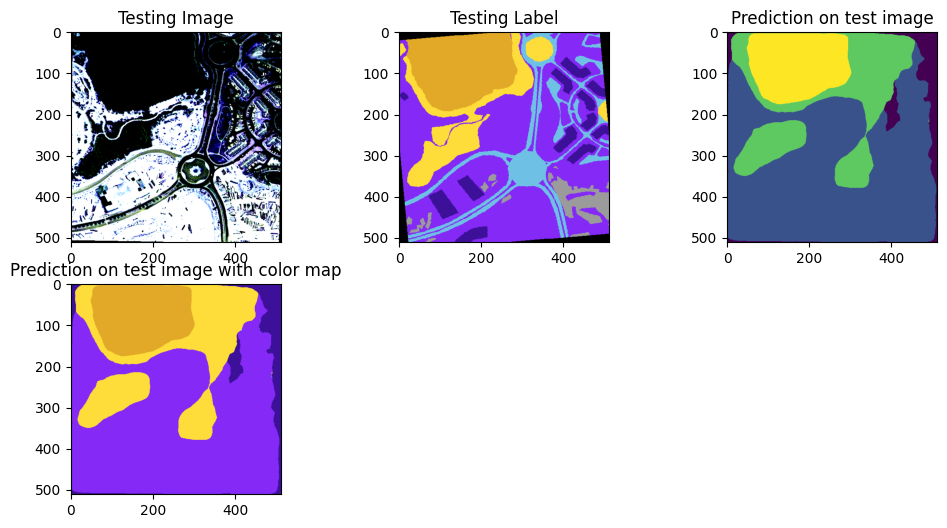

In [ ]:
import random
test_img_number = random.randint(0, len(val_data_loader)-1)
val_dataset = val_data_loader.dataset
test_img, test_mask = val_dataset[test_img_number]
test_img_batch = test_img.unsqueeze(0)


get_custom_unet.load_state_dict(torch.load('./model/custom_unet_best_model.pth'))
get_custom_unet.to(device) # Move model to device after loading state_dict
get_custom_unet.eval()


prediction = get_custom_unet(test_img_batch.to(device))
prediction = prediction.cpu().detach().numpy()
prediction = np.argmax(prediction, axis=1).squeeze(0) # Corrected: argmax on axis=1 and squeeze batch dim

#apply color mask
colored_mask = apply_color_map(prediction, color_map)

plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img.permute(1, 2, 0))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask.permute(1, 2, 0))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
plt.subplot(234) # Corrected subplot index
plt.title('Prediction on test image with color map')
plt.imshow(colored_mask)
plt.show()

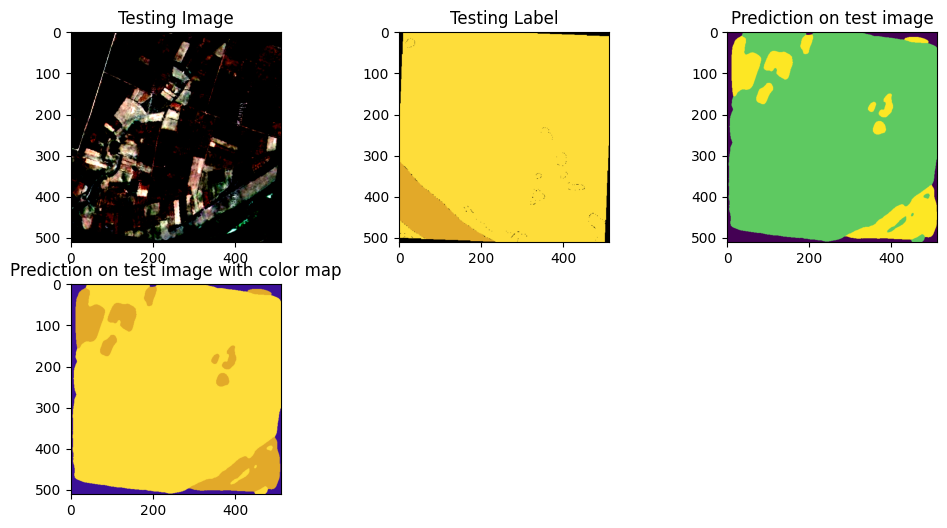

In [33]:
import random
test_img_number = random.randint(0, len(val_data_loader)-1)
val_dataset = val_data_loader.dataset
test_img, test_mask = val_dataset[test_img_number]
test_img_batch = test_img.unsqueeze(0)


get_custom_unet.load_state_dict(torch.load('./model/custom_unet_best_model.pth'))
get_custom_unet.to(device) # Move model to device after loading state_dict
get_custom_unet.eval()

with torch.no_grad():
  prediction = get_custom_unet(test_img_batch.to(device))
  prediction = prediction.cpu().detach().numpy()
  prediction = np.argmax(prediction, axis=1).squeeze(0) # Corrected: argmax on axis=1 and squeeze batch dim

  #apply color mask
  colored_mask = apply_color_map(prediction, color_map)

  plt.figure(figsize=(12, 6))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img.permute(1, 2, 0))
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(test_mask.permute(1, 2, 0))
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(prediction)
  plt.subplot(234) # Corrected subplot index
  plt.title('Prediction on test image with color map')
  plt.imshow(colored_mask)

plt.show()

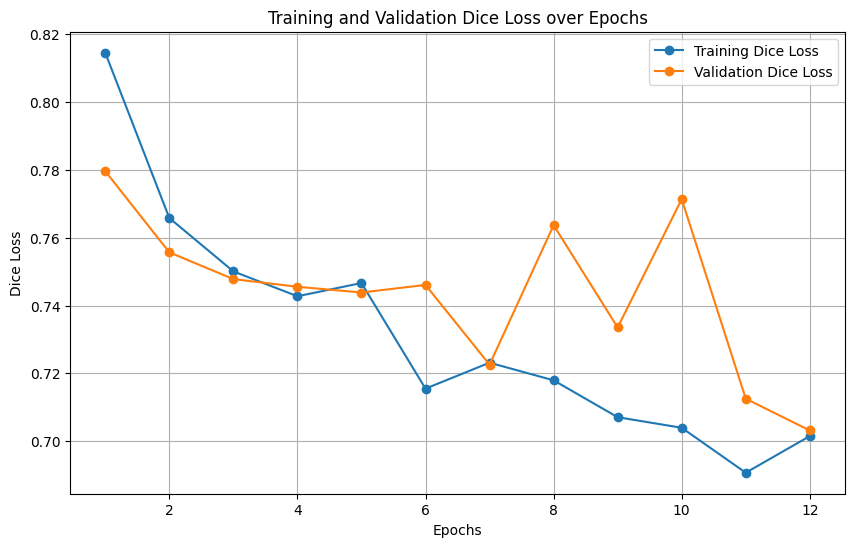

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 12 + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_logs_dict['dice_loss'], label='Training Dice Loss', marker='o')
plt.plot(epochs_range, valid_logs_dict['dice_loss'], label='Validation Dice Loss', marker='o')
plt.title('Training and Validation Dice Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()
plt.grid(True)
plt.savefig('./images/custom_unet_dice_loss.png')
plt.show()


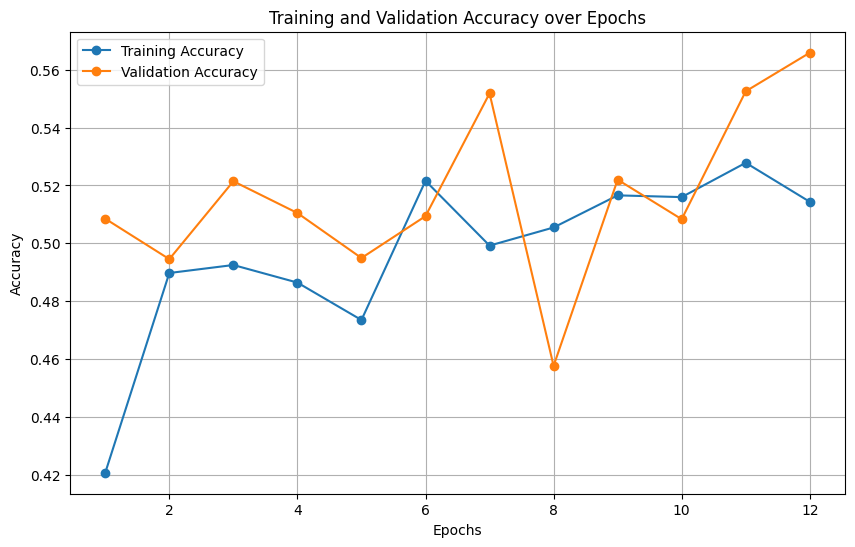

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 12 + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_logs_dict['Accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, valid_logs_dict['Accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('./images/custom_unet_accuracy.png')
plt.show()